<a href="https://colab.research.google.com/github/alicemoyon/green-ai-sandpit/blob/main/site/en/hub/tutorials/tf2_image_retraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [2]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TFLite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TFLite colab.


## Setup

In [3]:
!pip install codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
# Codecarbon EmissionsTracker custom class to return the energy consumption value



In [4]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.13.0
Hub version: 0.14.0
GPU is available


## Select the TF2 SavedModel module to use

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [32]:
#@title

model_name = "efficientnetv2-s-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300,
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: efficientnetv2-s-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2
Input size (384, 384)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [33]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

In [34]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [35]:
do_fine_tuning = False #@param {type:"boolean"}

In [36]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              20331360  
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 20337765 (77.58 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 20331360 (77.56 MB)
_________________________________________________________________


In [71]:
from codecarbon.emissions_tracker import BaseEmissionsTracker, EmissionsTracker
from typing import Any, Callable, Dict, List, Optional, Union
from codecarbon.core.util import suppress
from codecarbon.external.geography import CloudMetadata, GeoMetadata

# Define a new class that will return the energy_consumption

class BaseEnergyTracker(BaseEmissionsTracker):
      @suppress(Exception)
      def stop(self) -> Optional[float]:
        """
        Stops tracking the experiment
        :return: CO2 emissions in kgs
        """
        if self._start_time is None:
            logger.error("You first need to start the tracker.")
            return None

        if self._scheduler:
            self._scheduler.stop()
            self._scheduler = None
        else:
            logger.warning("Tracker already stopped !")
        for task_name in self._tasks:
            if self._tasks[task_name].is_active:
                self.stop_task(task_name=task_name)
        # Run to calculate the power used from last
        # scheduled measurement to shutdown
        # or if scheduler interval was longer than the run
        self._measure_power_and_energy()

        emissions_data = self._prepare_emissions_data()

        self._persist_data(emissions_data, experiment_name=self._experiment_name)

        self.final_emissions_data = emissions_data
        self.final_emissions = emissions_data.emissions
        return emissions_data.energy_consumed

class EnergyTracker(BaseEnergyTracker):
      """
      An online emissions tracker that auto infers geographical location,
      using the `geojs` API
      """

      def _get_geo_metadata(self) -> GeoMetadata:
          return GeoMetadata.from_geo_js(self._data_source.geo_js_url)

      def _get_cloud_metadata(self) -> CloudMetadata:
          if self._cloud is None:
              self._cloud = CloudMetadata.from_utils()
          return self._cloud


## Training the model

In [37]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [38]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
# added


from codecarbon import EmissionsTracker
tracker = EmissionsTracker(project_name="model1_training")
tracker.start()
try:
    # Add your model training or inference code here
finally:
     emissions = tracker.stop()


[codecarbon INFO @ 13:27:42] [setup] RAM Tracking...
[codecarbon INFO @ 13:27:42] [setup] GPU Tracking...
[codecarbon INFO @ 13:27:42] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:27:42] [setup] CPU Tracking...
[codecarbon WARNING @ 13:27:42] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 13:27:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 13:27:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 13:27:43] >>> Tracker's metadata:
[codecarbon INFO @ 13:27:43]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 13:27:43]   Python version: 3.10.12
[codecarbon INFO @ 13:27:43]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 13:27:43]   Available RAM : 12.678 GB
[codecarbon INFO @ 13:27:43]   CPU count: 2
[codecarbon INFO @ 13:27:43]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 13:27:43]   GPU

Epoch 1/3


[codecarbon INFO @ 13:27:59] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 13:27:59] Energy consumed for all GPUs : 0.000156 kWh. Total GPU Power : 37.4242799605158 W
[codecarbon INFO @ 13:27:59] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:27:59] 0.000353 kWh of electricity used since the beginning.


 79/183 [===========>..................] - ETA: 18s - loss: 0.9499 - accuracy: 0.8782

[codecarbon INFO @ 13:28:14] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 13:28:14] Energy consumed for all GPUs : 0.000445 kWh. Total GPU Power : 69.3095633184943 W
[codecarbon INFO @ 13:28:14] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:28:14] 0.000838 kWh of electricity used since the beginning.


163/183 [=========================>....] - ETA: 3s - loss: 0.8312 - accuracy: 0.8980

[codecarbon INFO @ 13:28:29] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 13:28:29] Energy consumed for all GPUs : 0.000733 kWh. Total GPU Power : 69.16544786063572 W
[codecarbon INFO @ 13:28:29] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:28:29] 0.001324 kWh of electricity used since the beginning.


183/183 [==============================] - 58s 229ms/step - loss: 0.8256 - accuracy: 0.8975 - val_loss: 0.6525 - val_accuracy: 0.9528
Epoch 2/3
  8/183 [>.............................] - ETA: 30s - loss: 0.6198 - accuracy: 0.9583

[codecarbon INFO @ 13:28:44] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 13:28:44] Energy consumed for all GPUs : 0.001010 kWh. Total GPU Power : 66.43183108189301 W
[codecarbon INFO @ 13:28:44] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:28:44] 0.001798 kWh of electricity used since the beginning.


 93/183 [==============>...............] - ETA: 15s - loss: 0.6204 - accuracy: 0.9473

[codecarbon INFO @ 13:28:59] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 13:28:59] Energy consumed for all GPUs : 0.001296 kWh. Total GPU Power : 68.93732871923112 W
[codecarbon INFO @ 13:28:59] Energy consumed for all CPUs : 0.000886 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:28:59] 0.002281 kWh of electricity used since the beginning.


179/183 [============================>.] - ETA: 0s - loss: 0.5956 - accuracy: 0.9559

[codecarbon INFO @ 13:29:14] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 13:29:14] Energy consumed for all GPUs : 0.001585 kWh. Total GPU Power : 69.31980167692319 W
[codecarbon INFO @ 13:29:14] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:29:14] 0.002766 kWh of electricity used since the beginning.


183/183 [==============================] - 41s 218ms/step - loss: 0.5965 - accuracy: 0.9555 - val_loss: 0.5940 - val_accuracy: 0.9528
Epoch 3/3
 37/183 [=====>........................] - ETA: 25s - loss: 0.5475 - accuracy: 0.9743

[codecarbon INFO @ 13:29:29] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 13:29:29] Energy consumed for all GPUs : 0.001871 kWh. Total GPU Power : 68.82697594378118 W
[codecarbon INFO @ 13:29:29] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W


 38/183 [=====>........................] - ETA: 25s - loss: 0.5463 - accuracy: 0.9750

[codecarbon INFO @ 13:29:29] 0.003250 kWh of electricity used since the beginning.


122/183 [===================>..........] - ETA: 10s - loss: 0.5345 - accuracy: 0.9769

[codecarbon INFO @ 13:29:44] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 13:29:44] Energy consumed for all GPUs : 0.002158 kWh. Total GPU Power : 69.14163697884385 W
[codecarbon INFO @ 13:29:44] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:29:44] 0.003733 kWh of electricity used since the beginning.


183/183 [==============================] - ETA: 0s - loss: 0.5386 - accuracy: 0.9733

[codecarbon INFO @ 13:29:59] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 13:29:59] Energy consumed for all GPUs : 0.002445 kWh. Total GPU Power : 68.71448664495335 W
[codecarbon INFO @ 13:29:59] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:29:59] 0.004216 kWh of electricity used since the beginning.


183/183 [==============================] - 40s 219ms/step - loss: 0.5386 - accuracy: 0.9733 - val_loss: 0.5414 - val_accuracy: 0.9556


[codecarbon INFO @ 13:30:02] Energy consumed for RAM : 0.000183 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 13:30:02] Energy consumed for all GPUs : 0.002513 kWh. Total GPU Power : 70.14238470808503 W
[codecarbon INFO @ 13:30:02] Energy consumed for all CPUs : 0.001635 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:30:02] 0.004330 kWh of electricity used since the beginning.


In [1]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

NameError: ignored

In [52]:
import logging
from codecarbon.output import LoggerOutput
log_name = "inference_log"
# Create a dedicated logger (log name can be the CodeCarbon project name for example)
_logger = logging.getLogger(log_name)

# Add a handler, see Python logging for various handlers (here a local file named after log_name)
_channel = logging.FileHandler(log_name + '.log')
_logger.addHandler(_channel)

# Set logging level from DEBUG to CRITICAL (typically INFO)
# This level can be used in the logging process to filter emissions messages
_logger.setLevel(logging.INFO)

# Create a CodeCarbon LoggerOutput with the logger, specifying the logging level to be used for emissions data messages
my_logger = LoggerOutput(_logger, logging.INFO)

Try out the model on an image from the validation data:

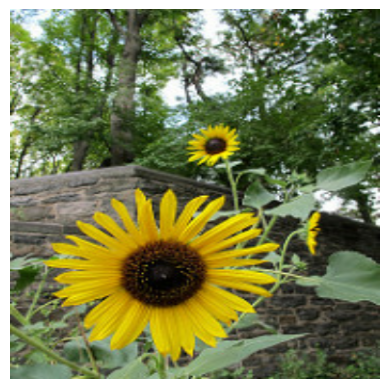

[codecarbon INFO @ 15:18:10] [setup] RAM Tracking...
[codecarbon INFO @ 15:18:10] [setup] GPU Tracking...
[codecarbon INFO @ 15:18:10] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:18:10] [setup] CPU Tracking...
[codecarbon WARNING @ 15:18:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:18:12] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:18:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 15:18:12] >>> Tracker's metadata:
[codecarbon INFO @ 15:18:12]   Platform system: Linux-5.15.120+-x86_64-with-glibc2.35
[codecarbon INFO @ 15:18:12]   Python version: 3.10.12
[codecarbon INFO @ 15:18:12]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 15:18:12]   Available RAM : 12.678 GB
[codecarbon INFO @ 15:18:12]   CPU count: 2
[codecarbon INFO @ 15:18:12]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 15:18:12]   GPU

1/1 [==============================] - 0s 32ms/step


[codecarbon INFO @ 15:18:12] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.7543792724609375 W
[codecarbon INFO @ 15:18:12] Energy consumed for all GPUs : 0.000001 kWh. Total GPU Power : 30.12762278709338 W
[codecarbon INFO @ 15:18:12] Energy consumed for all CPUs : 0.000001 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:18:12] 0.000003 kWh of electricity used since the beginning.
INFO:inference_log:{"timestamp": "2023-10-01T15:18:12", "project_name": "efficientnet_v2_s_infer", "run_id": "ae4367a1-cb9f-43a1-8b9c-a3ed56cfea14", "duration": 0.13329863548278809, "emissions": 6.217065876229402e-09, "emissions_rate": 4.664013141403963e-08, "cpu_power": 42.5, "gpu_power": 30.12762278709338, "ram_power": 4.7543792724609375, "cpu_energy": 1.467140681213803e-06, "gpu_energy": 9.938896840117062e-07, "ram_energy": 1.5423848747256368e-07, "energy_consumed": 2.6152688526980727e-06, "country_name": "Canada", "country_iso_code": "CAN", "region": "quebec", "cloud_provider": "", "cloud_regi

True label: sunflowers
Predicted label: sunflowers


In [72]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
tracker = EnergyTracker(project_name="efficientnet_v2_s_infer",
                           save_to_logger=True,
                           logging_logger=my_logger)
tracker.start()
try:
  prediction_scores = model.predict(np.expand_dims(image, axis=0))
finally:
  inference_emissions = tracker.stop()
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [73]:
inference_emissions

2.6152688526980727e-06

Finally, the trained model can be saved for deployment to TF Serving or TFLite (on mobile) as follows.

In [ ]:
saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

## Optional: Deployment to TensorFlow Lite

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TFLite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TFLite Interpreter to examine the resulting quality

  * Converting without optimization provides the same results as before (up to roundoff error).
  * Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
  * On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like Edge TPU.

In [ ]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_flowers_model_{model_name}.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TFLite Interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 50  #@param {type:"slider", min:0, max:700}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))